<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/download_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 36.1 MB/s eta 0:00:00


In [ ]:
# 1) Install dependencies (in Colab you’d run these once):
# !pip install astroquery pandas pillow

import os
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from PIL import Image
import matplotlib.pyplot as plt


# 2) Download the debiased GZ2 Table 1 (Hart et al. 2016)
#    https://arxiv.org/abs/1308.3496v2
#    This CSV has ~240 000 galaxies with ra, dec, dr7objid, and vote fractions.
url = 'https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz'
df = pd.read_csv(url, compression='gzip')


In [ ]:
# there are many classes of object in galaxyZoo but lets just select smooth or non-smooth galaxies
smooth   = (df['t01_smooth_or_features_a01_smooth_debiased']>0.7)
featured = (df['t01_smooth_or_features_a01_smooth_debiased']<0.2)

smooth_ra_dec   = df[smooth][['ra','dec']]
featured_ra_dec = df[featured][['ra','dec']]

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO

# 1. Helper to fetch an SDSS JPEG cutout
def fetch_sdss_cutout(ra, dec, scale=0.2, width=64, height=64, timeout=60):
    url = "https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
    params = {
        'ra': ra,
        'dec': dec,
        'scale': scale,
        'width': width,
        'height': height,
    }
    r = requests.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return Image.open(BytesIO(r.content))

# 2. Download some images
featured_imgs = []
for i in range(100):
    ra = featured_ra_dec.iloc[i]['ra']
    dec = featured_ra_dec.iloc[i]['dec']
    #print(ra,dec)

    try:
        img = fetch_sdss_cutout(ra, dec,
                                scale=0.9,   # ~0.9″/px
                                width=128,
                                height=128)

        img = np.array(img)
        img = np.mean(img, axis=2)
        featured_imgs.append(img)
    except Exception as e:
        print(f"Failed {ra, dec}: {e}")

smooth_imgs = []
for i in range(100):
    ra = smooth_ra_dec.iloc[i]['ra']
    dec = smooth_ra_dec.iloc[i]['dec']
    #print(ra,dec)

    try:
        img = fetch_sdss_cutout(ra, dec,
                                scale=0.9,   # ~0.9″/px
                                width=128,
                                height=128)

        img = np.array(img)
        img = np.mean(img, axis=2)
        smooth_imgs.append(img)
    except Exception as e:
        print(f"Failed {ra, dec}: {e}")


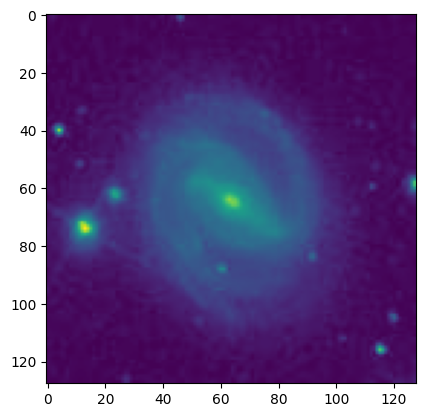

In [ ]:
plt.imshow(featured_imgs[7])

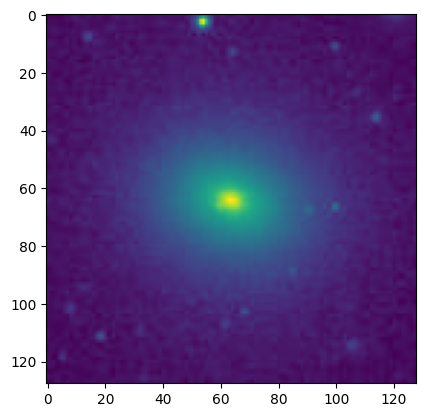

In [ ]:
plt.imshow(smooth_imgs[7])

In [ ]:
# join smooth and featured images
X = featured_imgs + smooth_imgs
X = np.array(X)

y = [0] * len(featured_imgs) + [1] * len(smooth_imgs)
y = np.array(y)

In [ ]:
# test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check resultant array shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 128, 128)
(160,)
(40, 128, 128)
(40,)


In [ ]:
# a simple CNN classification model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,137 (12.46 MB)

 Trainable params: 3,267,137 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 878ms/step - accuracy: 0.5326 - loss: 18.8847 - val_accuracy: 0.5250 - val_loss: 7.9879
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5055 - loss: 4.5784 - val_accuracy: 0.5750 - val_loss: 0.6537
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7475 - loss: 0.5133 - val_accuracy: 0.6000 - val_loss: 0.6472
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 802ms/step - accuracy: 0.8280 - loss: 0.3685 - val_accuracy: 0.7000 - val_loss: 0.6683
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 904ms/step - accuracy: 0.9490 - loss: 0.1935 - val_accuracy: 0.7750 - val_loss: 0.8637
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 819ms/step - accuracy: 0.9414 - loss: 0.1324 - val_accuracy: 0.7500 - val_loss: 1.1046
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 786ms/step - accuracy: 0.9915 - loss: 0.0584 - val_accuracy: 0.6750 - val_loss: 1.1235
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0570 - val_accuracy: 0.7000 - val_loss: 1.2250

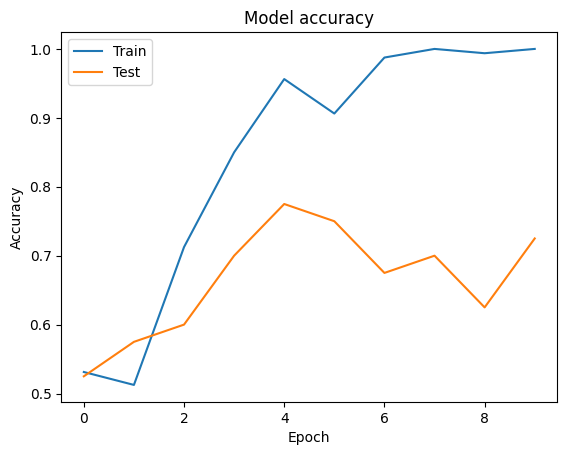

In [ ]:
# plot training and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')